# Hidden Markov Model for NER


In [ ]:
from app.travel_resolver.libs.nlp.data_processing import from_bio_file_to_examples

BIO_FILE = "data/bio/fr.bio/1k_samples.bio"

sentences, labels, vocab, unique_labels = from_bio_file_to_examples(BIO_FILE)

[nltk_data] Downloading package punkt_tab to /Users/az-r-
[nltk_data]     ow/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
from app.travel_resolver.libs.nlp.data_processing import process_sentence

processed_sentences = []
processed_labels = []

for sentence, label in zip(sentences, labels):
    p_sentence, p_label = process_sentence(
        sentence, stemming=True, labels_to_adapt=label
    )
    processed_sentences.append(p_sentence)
    processed_labels.append(p_label)

Splitting the data between **training** and **test** set. We will do an `80/20` split.


In [4]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, y_train, y_test = train_test_split(
    processed_sentences, processed_labels, test_size=0.2
)

In [5]:
def t2_given_t1(
    t2: str | int,
    t1: str | int,
    train_bag=y_train,
    unique_labels_mapping: dict = unique_labels,
):
    """
    Get the probability of getting t2 given t1 in the given labels

    Args:
      t2: str | int, the second tag
      t1: str | int, the first tag
      train_bag: list, the list of labels

    Returns:
      float, the probability of getting t2 given t1
    """
    t1 = t1 if isinstance(t1, int) else unique_labels_mapping[t1]
    t2 = t2 if isinstance(t2, int) else unique_labels_mapping[t2]
    count_t1 = 0
    count_t2_t1 = 0
    for row in train_bag:
        for index in range(len(row) - 1):
            if row[index] == t1:
                count_t1 += 1
            if row[index] == t1 and row[index + 1] == t2:
                count_t2_t1 += 1
    return count_t2_t1 / count_t1

In the next part, we will be getting the **transition matrix** which represents the _probability_ of transitioning from a state to another $P(S_2 | S_1)$. In our case it would be for example $P(O | \text{ARR-LOC})$.


In [6]:
import numpy as np

tags = list(unique_labels.keys())
n_tags = len(tags)

trans_matrix = np.zeros((n_tags, n_tags))

for t1 in range(n_tags):
    for t2 in range(n_tags):
        trans_matrix[t1][t2] = t2_given_t1(tags[t1], tags[t2])

trans_matrix

array([[0.74190199, 0.91056911, 0.52819333],
       [0.09489203, 0.06039489, 0.40506329],
       [0.16320598, 0.029036  , 0.06674338]])

In [7]:
import pandas as pd

trans_matrix_df = pd.DataFrame(trans_matrix, columns=tags, index=tags)

trans_matrix_df

,O,LOC-ARR,LOC-DEP
O,0.741902,0.910569,0.528193
LOC-ARR,0.094892,0.060395,0.405063
LOC-DEP,0.163206,0.029036,0.066743


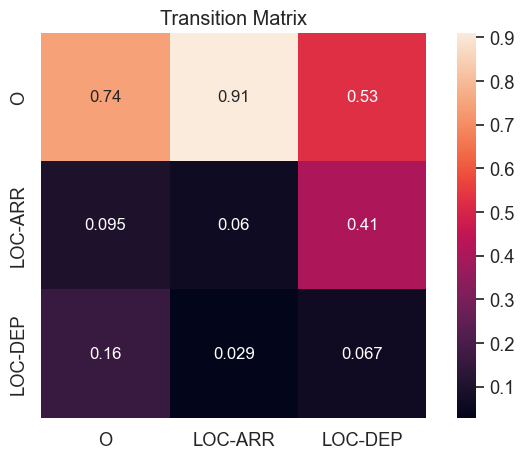

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

sns.set(font_scale=1.2)

sns.heatmap(trans_matrix_df, annot=True, square=True, annot_kws={"fontsize": 12})

plt.title("Transition Matrix")

plt.show()

In [9]:
def get_emission_prob_dict(
    sentences: list[str] = train_sentences,
    labels: list[int] = y_train,
    tags: dict = unique_labels,
):
    """
    Given a bunch of sentences and their labels, get the emission probability of each word given each tag

    Parameters:
    sentences (list): The list of sentences
    labels (list): The list of labels
    tags (dict): The dictionary of tags

    Returns:
    dict: The dictionary of emission probabilities
    """
    tags = list(tags.keys())
    word_label_count = {}
    tag_count = {tag: 0 for tag in tags}
    for i in range(len(sentences)):
        for word, label in zip(sentences[i].split(" "), labels[i]):
            if word not in word_label_count:
                word_label_count[word] = {tag: 0 for tag in tags}
            word_label_count[word][tags[label]] += 1
            tag_count[tags[label]] += 1

    for word in word_label_count:
        for tag in word_label_count[word]:
            if word_label_count[word][tag] == 0:
                word_label_count[word][tag] = 0
                continue
            word_label_count[word][tag] /= tag_count[tag]

        sum_probs = sum(word_label_count[word].values())

        if sum_probs > 1:
            print(f"Sum of probabilities for word {word} is {sum_probs}")

    word_label_count["<UNK>"] = {tag: 0 for tag in tags}
    return word_label_count

In [10]:
em_prob_dict = get_emission_prob_dict()

em_prob_df = pd.DataFrame(em_prob_dict).T

em_prob_df.head(10)

,O,LOC-ARR,LOC-DEP
est-ce,0.000712,0.000000,0.000000
loin,0.000712,0.000000,0.000000
d'all,0.001247,0.000000,0.000000
mery-sur-ois,0.000000,0.000000,0.002301
ale,0.000000,0.001161,0.000000
?,0.028317,0.000000,0.000000
je,0.083170,0.000000,0.000000
voudr,0.041318,0.000000,0.000000
trouv,0.041852,0.000000,0.000000
vol,0.038112,0.000000,0.000000


In [11]:
em_prob = em_prob_df.to_numpy()

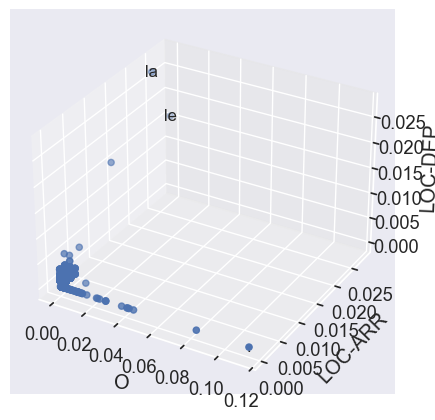

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection="3d")

xx = em_prob[:, 0]
yy = em_prob[:, 1]
zz = em_prob[:, 2]

xlabel = list(em_prob_df.columns)[0]
ylabel = list(em_prob_df.columns)[1]
zlabel = list(em_prob_df.columns)[2]

# Words with the highest probability on each axis
x_highest_i = np.argmax(em_prob[:, 0])
y_highest_i = np.argmax(em_prob[:, 1])
z_highest_i = np.argmax(em_prob[:, 2])

for i in enumerate([x_highest_i, y_highest_i, z_highest_i]):
    ax.text(
        xx[i[1]],
        yy[i[1]],
        zz[i[1]],
        em_prob_df.index[i[1]],
        fontsize=12,
        ha="center",
        va="center",
    )

ax.scatter(xx, yy, zz)

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_zlabel(zlabel)

plt.show()

In [13]:
def get_start_prob(labels: list[int] = y_train, tags: dict = unique_labels):
    """
    Get the start probability of each tag

    Parameters:
    labels (list): The list of labels
    tags (dict): The dictionary of tags

    Returns:
    dict: The dictionary of start probabilities
    """
    tags = list(tags.keys())
    start_prob = {tag: 0 for tag in tags}
    for label in labels:
        start_prob[tags[label[0]]] += 1
    total_count = sum(start_prob.values())
    for tag in start_prob:
        start_prob[tag] /= total_count
    return start_prob

In [14]:
startprob = get_start_prob()

startprob = np.array(list(startprob.values()))

startprob

array([1., 0., 0.])

Since we already have the model parameters, we don't need to use the automatic model estimation with `fit()`. Therefore, we will pass the probabilities directly to the model and move on to the predictions.


In [16]:
from hmmlearn.hmm import CategoricalHMM

vocab = list(em_prob_dict.keys())

hmm = CategoricalHMM(n_components=n_tags, n_iter=100)

hmm.n_features = len(vocab)
hmm.startprob_ = startprob
hmm.transmat_ = trans_matrix.T
hmm.emissionprob_ = em_prob.T

In [15]:
em_prob.T.shape

(3, 1339)

In [17]:
def encode_sentence(sentence: str, vocab: list[str]):
    """
    Encode a sentence into a list of integers

    Parameters:
    sentence (str): The sentence to encode
    vocab (list): The vocabulary

    Returns:
    list: The list of integers
    """
    return [
        vocab.index(word) if word in vocab else vocab.index("<UNK>")
        for word in sentence.split(" ")
    ]

In [18]:
from app.travel_resolver.libs.nlp.data_processing import process_sentence

vocab = list(em_prob_dict.keys())

test_sentence = "Je voudrais voyager de Montpellier à Paris."

test_sentence = process_sentence(test_sentence, stemming=True)

test_sentence_encoded = encode_sentence(test_sentence, vocab)

test_sentence_encoded = np.array(test_sentence_encoded).reshape(-1, 1)

predicted_labels = hmm.predict(test_sentence_encoded)

for word, label in zip(test_sentence, predicted_labels):
    print(f"{word}: {list(unique_labels.keys())[label]}")

j: O
e: O
 : O
v: LOC-DEP
o: LOC-DEP
u: O


In [19]:
test_sentences_encoded = [
    encode_sentence(sentence, vocab) for sentence in test_sentences
]
test_sentences_lengths = [len(sentence) for sentence in test_sentences_encoded]


test_sentences_encoded_flat = [
    item for sublist in test_sentences_encoded for item in sublist
]
test_sentences_encoded = np.array(test_sentences_encoded_flat).reshape(-1, 1)

predicted_labels_test = hmm.predict(test_sentences_encoded, test_sentences_lengths)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_test = [item for sublist in y_test for item in sublist]

accuracy_score = accuracy_score(y_test, predicted_labels_test)
precision_score = precision_score(y_test, predicted_labels_test, average="weighted")
recall_score = recall_score(y_test, predicted_labels_test, average="weighted")
f1_score = f1_score(y_test, predicted_labels_test, average="weighted")

print(f"Accuracy: {accuracy_score}")
print(f"Precision: {precision_score}")
print(f"Recall: {recall_score}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.7044728434504792
Precision: 0.8437797024042935
Recall: 0.7044728434504792
F1 Score: 0.7390763122386325
